In [1]:
import pandas as pd
import numpy as np
import sklearn
import seaborn as sns
import networkx as nx

from matplotlib import pyplot as plt
from sklearn import model_selection

import codecs
import json
import os

In [2]:
IMPORT = True
EXPORT = True
DISPLAY = True
VERBOSE = False
DATA_DIR = "../new_data"
SEED = 221

In [3]:
def get_datasets(type='medium'):
    if type not in ['medium', 'all', 'mini']:
        raise Exception("Invalid type!")
        
    train_df = pd.read_csv(DATA_DIR + f'/train_{type}.csv').set_index("request_id")
    dev_df = pd.read_csv(DATA_DIR + f'/val_{type}.csv').set_index("request_id")
    return train_df, dev_df

In [4]:
train_df, dev_df = get_datasets('medium')

In [44]:
df = dev_df
G = nx.Graph()
import ast

for i, row in df.iterrows():
    username = row.requester_username
    pizza = row.requester_received_pizza
    subreddits = row.requester_subreddits_at_request
    for subreddit in ast.literal_eval(str(subreddits)):
        G.add_edge(username, subreddit)

In [45]:
# ## Connectivity
# One more preprocessing step - get rid of extra disconnected components
nx.number_connected_components(G)
for component in nx.connected_components(G):
    print(len(component))
    if len(component) < 10:
        print(component)
print(len(G))
G = G.subgraph(next(nx.connected_components(G))).copy()
print(len(G))

2315
2315
2315


In [46]:
pos = nx.drawing.layout.bipartite_layout(G, list(df.requester_username))

In [47]:
requesters = list(df.requester_username.unique())
subreddits = [n for n in G.nodes() if n not in requesters]

In [48]:
len(requesters), len(subreddits), len(G.nodes())

(90, 2225, 2315)

## Bipartite graph starting

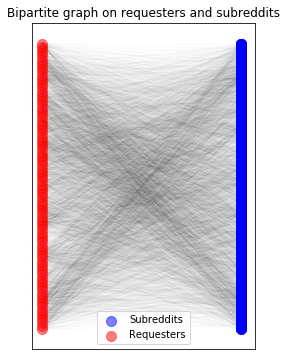

In [49]:
plt.figure(figsize=(4, 6))
nx.draw_networkx_nodes(G, nodelist=subreddits, pos=pos, alpha=0.5, node_size=100, label='Subreddits', node_color='b')
nx.draw_networkx_nodes(G, nodelist=requesters, pos=pos, alpha=0.5, node_size=100, label='Requesters', node_color='r')
nx.draw_networkx_edges(G, pos=pos, linewidths=0.001, alpha=0.01, node_size=100)
plt.title("Bipartite graph on requesters and subreddits")
plt.legend()
plt.show()

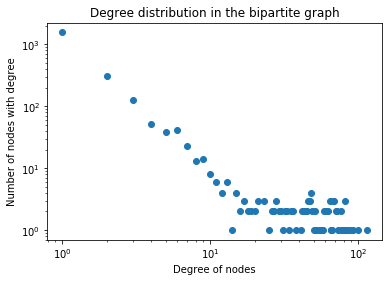

In [50]:
# ## Degree analysis
import collections
degrees = G.degree
#degrees = {k:v for (k, v) in dict(degrees).items() if k in requesters}
degree_count = dict(collections.Counter(dict(degrees).values()))

if (DISPLAY):
    plt.loglog()
    plt.plot(list(degree_count.keys()), list(degree_count.values()), linestyle=' ', marker='o')
    plt.title("Degree distribution in the bipartite graph")
    plt.xlabel("Degree of nodes")
    plt.ylabel("Number of nodes with degree")
    plt.show()

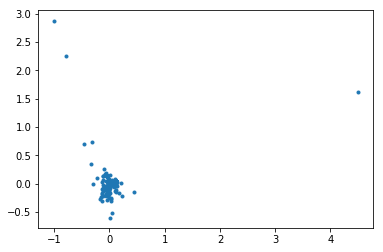

In [51]:
# ## Spectral analysis
node_ordering = G.nodes()
Adj = nx.linalg.adjacency_matrix(G)


# Spectral Clustering
from sklearn.manifold import SpectralEmbedding
model = SpectralEmbedding(n_components=2,
                              affinity='precomputed',
                              random_state=SEED,
                              n_neighbors=None,
                              n_jobs=None)
spectral_embedding = model.fit_transform(Adj.toarray())

if (DISPLAY):
    # plot Spectral Clustering
    plt.scatter(spectral_embedding[:,0], spectral_embedding[:, 1])
    plt.show()

In [97]:
from sklearn.manifold import TSNE

model = TSNE(n_components=2, perplexity=100.0, early_exaggeration=12.0,
             learning_rate=200.0, n_iter=1000, n_iter_without_progress=300,
             min_grad_norm=1e-07, random_state=SEED)
embedding = model.fit_transform(spectral_embedding)


embedding = pd.DataFrame(embedding, index=node_ordering)
embedding.head()

,0,1
dity4u,20.768450,14.249822
webcomics,9.548995,-2.714774
funny,18.843052,12.793925
Birbs,9.556873,-2.684278
ehlersdanlos,9.507523,-2.788154


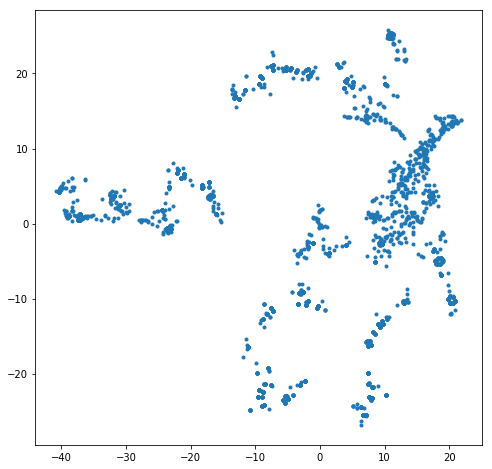

In [98]:
if (DISPLAY):
    # plot t-SNE
    plt.figure(figsize=(8, 8))
    plt.scatter(embedding.iloc[:,0], embedding.iloc[:, 1])
    plt.show()

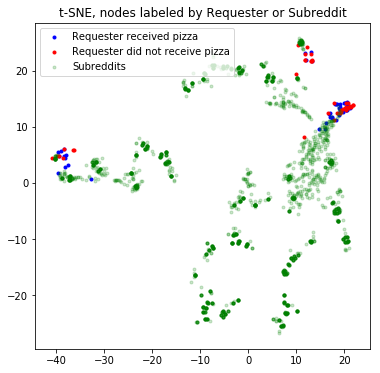

In [101]:
if (DISPLAY):
    plt.figure(figsize=(6, 6))
    plt.rcParams["scatter.marker"] = '.'
    group1 = df[df.requester_received_pizza == 1].requester_username.unique()
    group2 = df[df.requester_received_pizza == 0].requester_username.unique()
    
    group3 = subreddits
    plt.scatter(embedding.loc[group1].iloc[:,0],
                embedding.loc[group1].iloc[:,1], alpha=1.0, label="Requester received pizza", marker='.', color='b')
    plt.scatter(embedding.loc[group2].iloc[:,0],
                embedding.loc[group2].iloc[:,1], alpha=1.0, label="Requester did not receive pizza", marker='.', color='r')
    plt.scatter(embedding.loc[group3].iloc[:,0],
                embedding.loc[group3].iloc[:,1], alpha=0.2, label="Subreddits", marker='.', color='g')
    plt.legend()
    plt.title("t-SNE, nodes labeled by Requester or Subreddit")
    plt.show()

# Naive baseline

In [55]:
adj_features = pd.DataFrame(Adj.toarray(), index=node_ordering, columns=node_ordering)

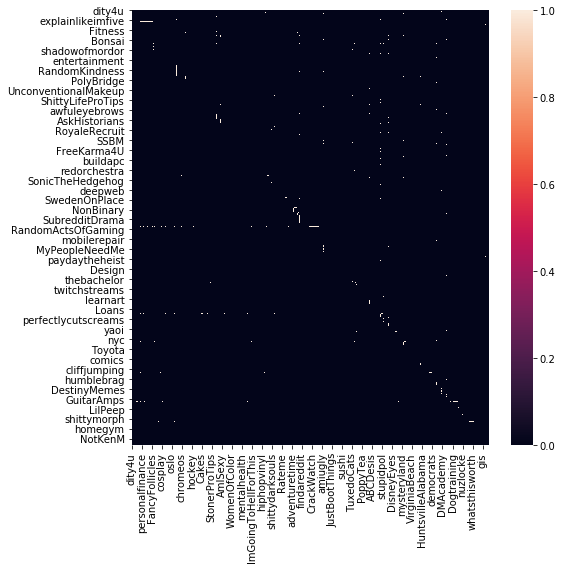

In [56]:
plt.figure(figsize=(8, 8))
sns.heatmap(adj_features)

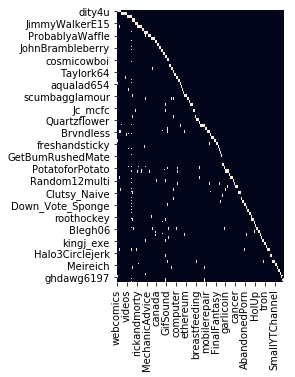

In [103]:
plt.figure(figsize=(3, 5))
sns.heatmap(adj_features.loc[requesters][subreddits].dropna(axis=0), cbar=False)

In [58]:
X = adj_features.loc[df.requester_username][subreddits]
X['received_pizza'] = df.set_index('requester_username').requester_received_pizza

In [59]:
dat = X.dropna(axis=0).dropna(how='all', axis=1)

In [ ]:
X_train = dat[[col for col in dat.columns if col != 'received_pizza']]
y_train = dat['received_pizza']

In [60]:
X_dev = dat[[col for col in dat.columns if col != 'received_pizza']]
y_dev = dat['received_pizza']

In [61]:
lr = sklearn.linear_model.LogisticRegression()

In [70]:
all_subreddits = X_train.columns.union(X_dev.columns)
X_train = pd.concat([X_train, pd.DataFrame(columns=[col for col in all_subreddits if col not in X_train.columns])])
X_dev = pd.concat([X_dev, pd.DataFrame(columns=[col for col in all_subreddits if col not in X_dev.columns])])

In [76]:
X_train = X_train[all_subreddits].fillna(value=0)
X_dev = X_dev[all_subreddits].fillna(value=0)

In [84]:
(X_train.columns == X_dev.columns).all()

True

In [79]:
lr.fit(X_train, y_train)
lr.score(X_dev, y_dev)

0.5222222222222223

In [80]:
y_pred = lr.predict(X_dev)

In [81]:
sklearn.metrics.roc_auc_score(y_dev, y_pred)

0.4838056680161943

In [82]:
sklearn.metrics.accuracy_score(y_dev, y_pred)

0.5222222222222223

In [86]:
communities = nx.algorithms.community.label_propagation.label_propagation_communities(G)

In [87]:
communities

<generator object label_propagation_communities at 0x7f8d7fa10eb8>

In [89]:
for c in communities:
    print(c)

{'Dukedyduke', 'thinkpad', 'beerporn', 'creepyPMs', 'freedompop', 'Ooer', 'transgamers', 'ftmcirclejerk', 'FTMMen', 'ftm', 'dragonsfuckingcars', 'lgbt', 'doujinshi', 'relationship_advice', 'ffxiv', 'u_Dukedyduke', 'transpassing', 'StardewValley', 'HENTAI_GIF', 'Bestbuy', 'NoTraps', 'Sneks', 'gfur', 'AndroidQuestions', 'transgendercirclejerk', 'sadcats', 'perfectlycutscreams', 'Louisville', 'GameSale', 'gay_irl', 'transtimelines', 'askgaybros', 'beer', 'gatekeeping', 'grilledcheese', 'vnsuggest', 'blurrypicturesofcats', 'preyingmantis', 'gamecollecting', 'amiugly', 'creepyasterisks'}
{'netflix', 'buildapcforme', 'AskTrumpSupporters', 'Korean', 'LivestreamFail', 'MLBTheShow', 'Beck4', 'Dungeons_and_Dragons', 'mlb', 'SuggestALaptop', 'dndnext', 'DungeonsAndDragons', 'criticalrole', 'warcraftlore', 'cellphones', 'Smartphones'}
{'GaySoundsShitposts', 'UnsolvedMysteries', 'wheredidthesodago', '2meirl4meirl', 'nonononoyes', 'mylittlepony', 'furry_irl', 'onetruegod', 'MetalMemes', 'AgainstHate